<a href="https://colab.research.google.com/github/gulmert89/dsBootcamp/blob/master/odev115_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ödev 11.5 - Derin Öğrenmeye Giriş: Recurrent Neural Network (RNN) Modelleri

1) Derste gösterildiği gibi <code>pip install yfinance</code> komutunu kullanarak, kendinizin karar vereceği 2 farkli hisse senedi seçin ve bu hisse senetlerinin gelecek fiyatlarını LSTM kullanarak tahmin (1-step forecast) edin.

2) RNN'de karşılaşılan sorunları ve neden LSTM'e ihtiyaç duyulduğunu kısaca tartışın.

3) LSTM'de yer alan epoch ve batch size parametrelerinin ne olduğunu araştırın. 1. soruyu farklı epoch ve batch size değerleri ile tekrar çözüp, sonucu rapor edin.

---
# 1. Introduction

## 1.1 Import the regulars

In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install yfinance
import yfinance as yf
from keras.utils import to_categorical
from keras import models, layers

     |████████████████████████████████| 5.5MB 4.0MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=96930cacfbd708dd756b0b82384fb60890f4844e6444d1075f4a2d96ddd41fe9
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


## 1.2 Prepare the dataset

In [3]:
intel = yf.download("INTC", 
                  start="1990-01-01", 
                  end="2020-01-01", 
                  interval="1d", 
                  prepost=True)
amd = yf.download("AMD", 
                  start="1990-01-01", 
                  end="2020-01-01", 
                  interval="1d", 
                  prepost=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
intel["Average"] = (intel.High + intel.Low) / 2
amd["Average"] = (amd.High + amd.Low) / 2
intel.drop(columns=["High", "Low"], inplace=True)
amd.drop(columns=["High", "Low"], inplace=True)

intel.tail()

,Open,Close,Adj Close,Volume,Average
Date,,,,,
2019-12-24,59.250000,59.410000,58.390232,6313200,59.320000
2019-12-26,59.410000,59.820000,58.793194,11480300,59.599998
2019-12-27,59.910000,60.080002,59.048733,14085800,60.190001
2019-12-30,59.990002,59.619999,58.596626,12750500,59.715000
2019-12-31,59.619999,59.849998,58.822678,14432900,59.645000


## 1.3 Visualization

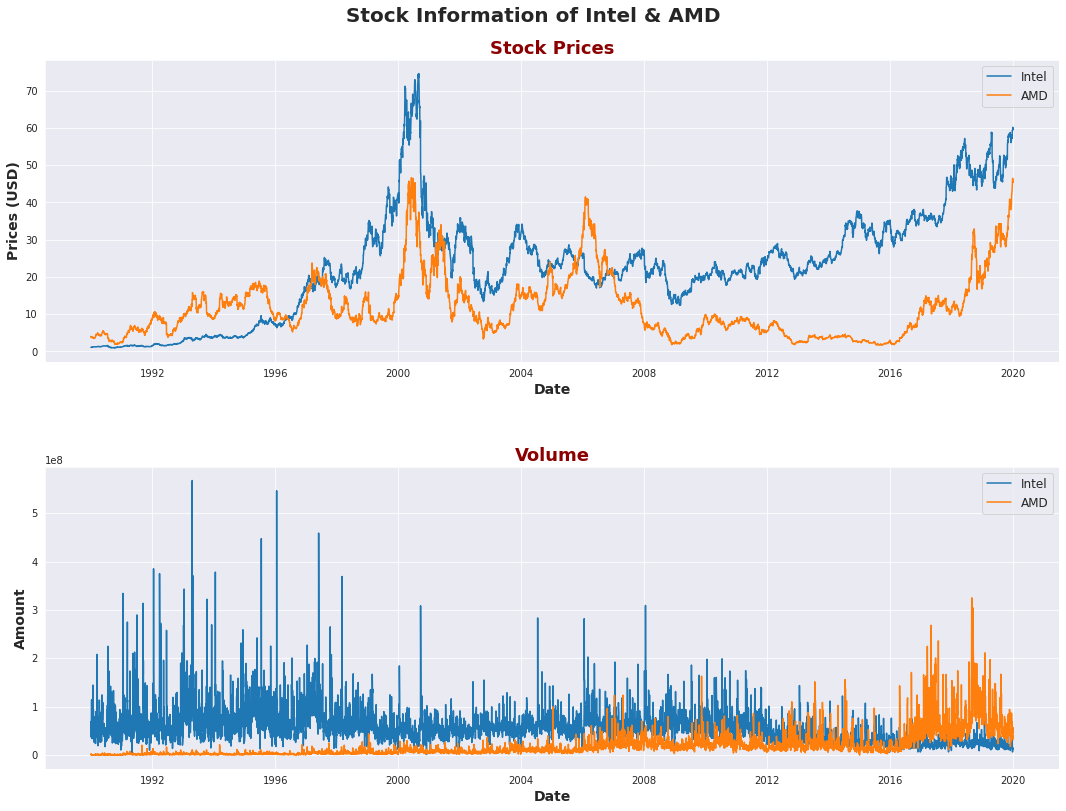

In [5]:
%matplotlib inline
sns.set_style("darkgrid")
plt.figure(figsize=(16,12))
plt.suptitle("Stock Information of Intel & AMD", size=20, weight="bold")
# stock prices
# INTEL
plt.subplot(2,1,1)
plt.title("Stock Prices", color="darkred", size=18, weight="bold")
plt.plot(intel.index, intel.Average, label="Intel")
# AMD
plt.plot(amd.index, amd.Average, label="AMD")
plt.xlabel("Date", size=14, weight="bold")
plt.ylabel("Prices (USD)", size=14, weight="bold")
plt.legend(loc="best", fontsize="large")

# volume
# INTEL
plt.subplot(2,1,2)
plt.title("Volume", color="darkred", size=18, weight="bold")
plt.plot(intel.index, intel.Volume, label="Intel")
# AMD
plt.plot(amd.index, amd.Volume, label="AMD")
plt.xlabel("Date", size=14, weight="bold")
plt.ylabel("Amount", size=14, weight="bold")
plt.legend(loc="best", fontsize="large")

plt.tight_layout(pad=5)
plt.show()

# 2. Recurrent Neural Network

## 2.1 Preparation of train & test sets

In [6]:
from sklearn.preprocessing import MinMaxScaler
scale_01 = MinMaxScaler(feature_range=(0, 1))

In [7]:
# scale the sets (Volume & Average)
intel_input = scale_01.fit_transform(intel.iloc[:, [-2, -1]].values)
amd_input = scale_01.fit_transform(amd.iloc[:, [-2, -1]].values)

We will use the prices and trading volume over the last 100 trading days to estimate stock prices. <br>We will use 30% of our data as a test set. Our target variable will be the price today.

In [8]:
lookback= 100

# intel set
test_size = int(.3 * len(intel_input))
X_intel, y_intel = [], []
for i in range(len(intel_input) - lookback - 1):
    t = []
    for j in range(0, lookback):
        t.append(intel_input[[(i + j)], :])
    X_intel.append(t)
    y_intel.append(intel_input[i + lookback, 1])

# amd set
X_amd, y_amd = [], []
for i in range(len(amd_input) - lookback - 1):
    t = []
    for j in range(0, lookback):
        t.append(amd_input[[(i + j)], :])
    X_amd.append(t)
    y_amd.append(amd_input[i + lookback, 1])

In [9]:
X_intel, y_intel = np.array(X_intel), np.array(y_intel)
X_amd, y_amd = np.array(X_amd), np.array(y_amd)

X_test_intel = X_intel[:(test_size + lookback)]
X_test_amd = X_amd[:(test_size + lookback)]

# reshape w.r.t the model
X_intel = X_intel.reshape(X_intel.shape[0], lookback, 2)
X_amd = X_amd.reshape(X_amd.shape[0], lookback, 2)

X_test_intel = X_test_intel.reshape(X_test_intel.shape[0], lookback, 2)
X_test_amd = X_test_amd.reshape(X_test_amd.shape[0], lookback, 2)

In [10]:
print("Shape of an RNN consists of (batch_size, timesteps, input_features):")
print(np.shape(X_intel))

Shape of an RNN consists of (batch_size, timesteps, input_features):
(7458, 100, 2)


## 2.2 Preparation of the model

In [11]:
from keras import models, layers

### 2.2.1 Baseline Model:

In [12]:
model = models.Sequential()
model.add(layers.LSTM(units=32, 
                      return_sequences=True, 
                      input_shape=(X_intel.shape[1], 2)))
model.add(layers.LSTM(units=32))
model.add(layers.Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 32)           4480      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 12,833
Trainable params: 12,833
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [14]:
history_intel = model.fit(X_intel, y_intel, 
                epochs=100, 
                batch_size=128, 
                verbose=0, 
                validation_split=0.2)

In [15]:
history_amd = model.fit(X_amd, y_amd, 
                        epochs=100, 
                        batch_size=128, 
                        verbose=0, 
                        validation_split=0.2)

### 2.2.2 Initial Loss Values

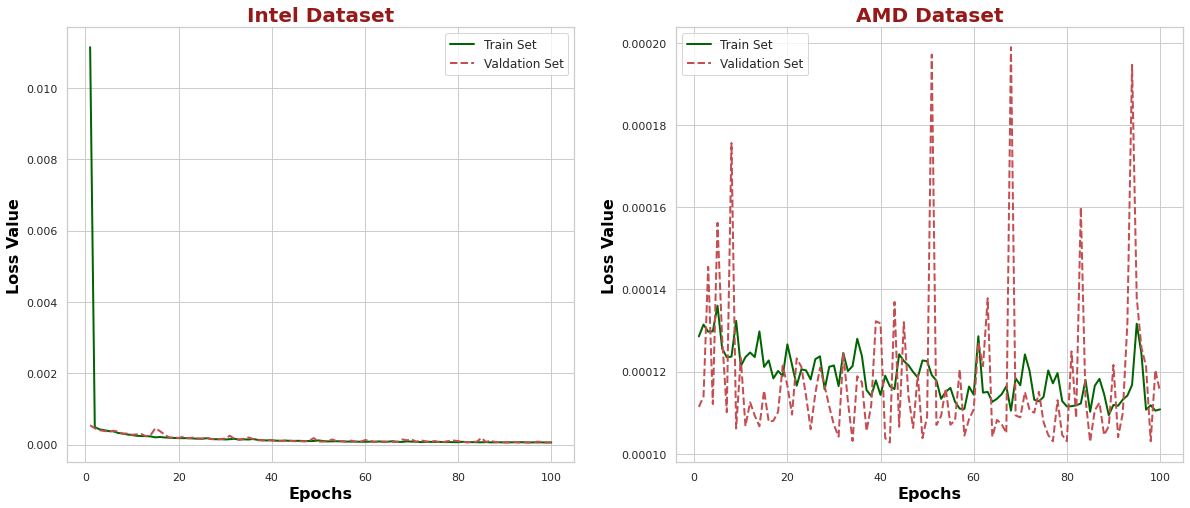

In [16]:
sns.set(style="whitegrid")
title_font = {"family":"sans", 
              "color":"darkred", 
              "size":20, 
              "weight":"bold", 
              "alpha":0.9}
axis_font = {"family":"sans-serif", 
              "color":"black", 
              "size":16, 
              "weight":"bold"}
# plot the graphs
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.title("Intel Dataset", fontdict=title_font)
plt.plot(range(1, len(history_intel.history["loss"])+1), 
         history_intel.history["loss"], 
         color="darkgreen", linewidth=2, label="Train Set")
plt.plot(range(1, len(history_intel.history["val_loss"])+1), 
         history_intel.history["val_loss"], 
        "r--", linewidth=2, label="Valdation Set")
plt.xlabel("Epochs", fontdict=axis_font)
plt.ylabel("Loss Value", fontdict=axis_font)
plt.legend(fontsize="medium", loc=0)

plt.subplot(1,2,2)
plt.title("AMD Dataset", fontdict=title_font)
plt.plot(range(1, len(history_amd.history["loss"])+1), 
         history_amd.history["loss"], 
         color="darkgreen", linewidth=2, label="Train Set")
plt.plot(range(1, len(history_amd.history["val_loss"])+1), 
         history_amd.history["val_loss"], 
        "r--", linewidth=2, label="Validation Set")
plt.xlabel("Epochs", fontdict=axis_font)
plt.ylabel("Loss Value", fontdict=axis_font)
plt.legend(fontsize="medium", loc=0)

plt.show()

### 2.2.3 Initial Predictions

In [17]:
predict_intel = model.predict(X_test_intel)
predict_amd = model.predict(X_test_amd)

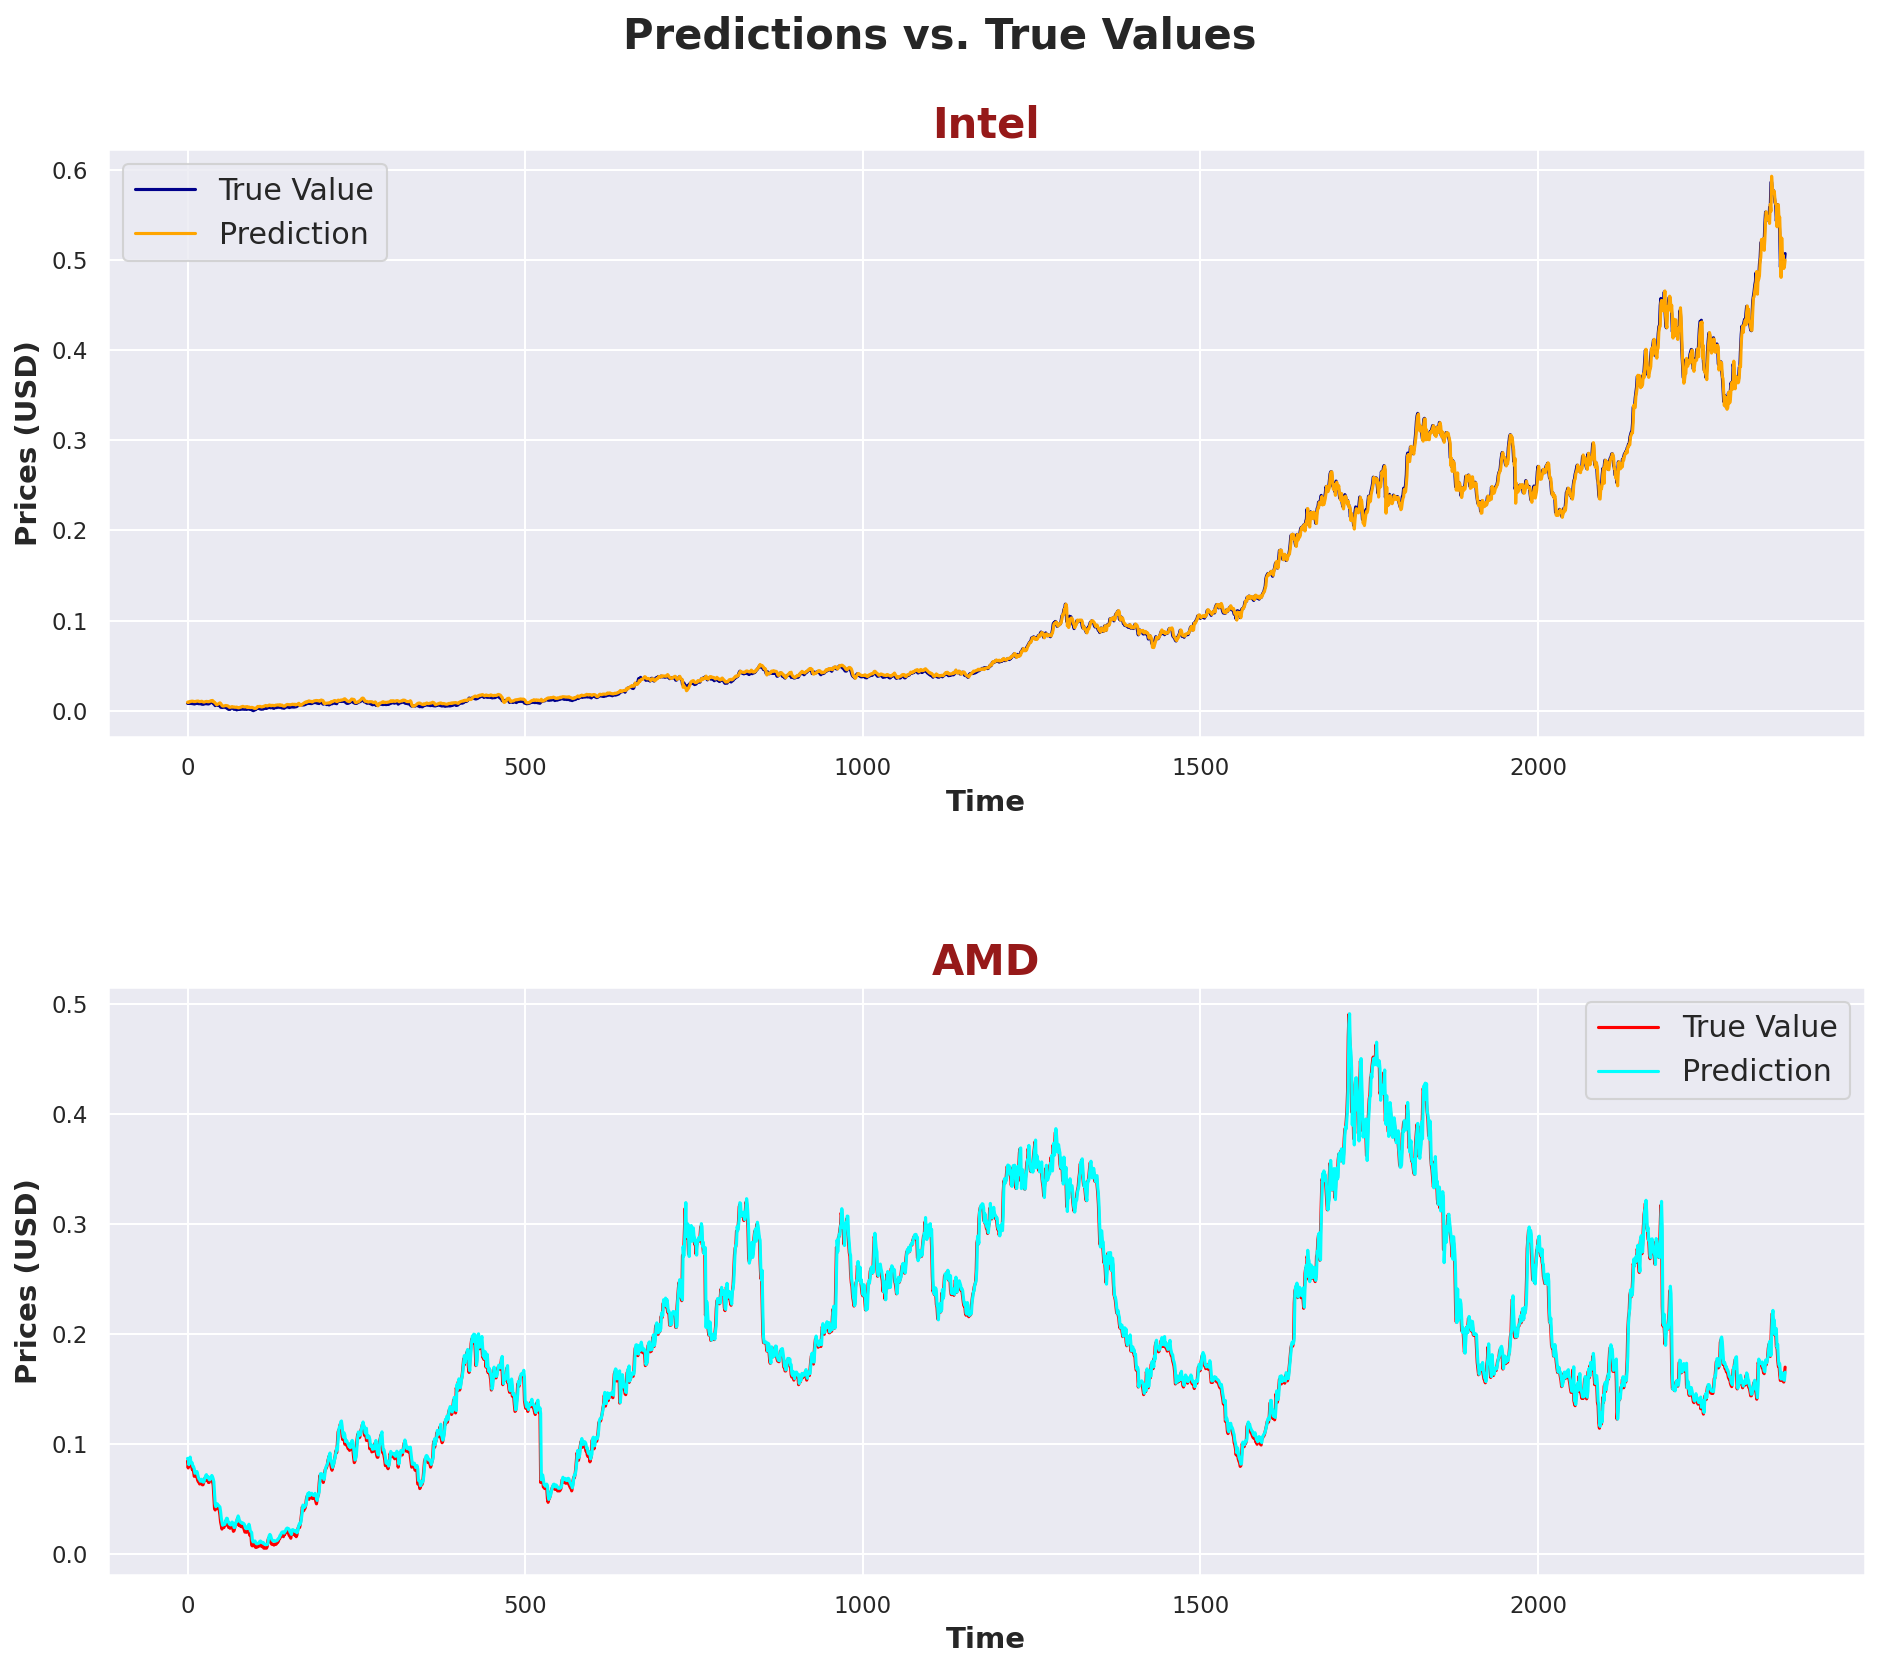

In [22]:
sns.set_style("darkgrid")
plt.figure(figsize=(14,12), dpi=150)
plt.suptitle("Predictions vs. True Values", size=20, weight="bold")
# INTEL
plt.subplot(2,1,1)
plt.title("Intel", fontdict=title_font)
plt.plot(intel_input[lookback:(test_size + (2 * lookback)),1], 
         label="True Value", color="darkblue")
plt.plot(predict_intel, label="Prediction", color="orange")
plt.xlabel("Time", size=14, weight="bold")
plt.ylabel("Prices (USD)", size=14, weight="bold")
plt.legend(loc="best", fontsize="large")
# AMD
plt.subplot(2,1,2)
plt.title("AMD", fontdict=title_font)
plt.plot(amd_input[lookback:(test_size + (2 * lookback)),1], 
         label="True Value", color="red")
plt.plot(predict_amd, label="Prediction", color="cyan")
plt.xlabel("Time", size=14, weight="bold")
plt.ylabel("Prices (USD)", size=14, weight="bold")
plt.legend(loc="best", fontsize="large")

plt.tight_layout(pad=5)
plt.show()